# Plot domains used
This notebook generates figures of the domains used to define the bounds of cities included in Project CCHAIN, for presentation purposes

In [19]:
import os, sys
from pathlib import Path
import time

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr

from functools import partial
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.ticker import FuncFormatter
from matplotlib import colors
import glob

import ast
sys.path.append("../../") 

In [3]:
RAW_INPUT_PATH = Path("../../data/01-raw/")
INPUT_PATH = Path("../../data/02-processed/")
RESULTS_PATH = Path("../../data/03-results/")
FIGS_PATH = Path("../../figs/")
YEARS = np.arange(2003,2023,1)
VARIABLE = 'tmax'
metrics_columns = ['rmse','mae','binary-accuracy']

RESOLUTION = 0.02
if VARIABLE == 'precip': 
    evaluation_years = [2008,2009,2010,2016,2017,2018]
    VARIABLE_LR = 'tp'
elif VARIABLE in ['tmin', 'tmax']: 
    evaluation_years = [2008,2009,2010,2016]
    VARIABLE_LR = 't2m_min' if VARIABLE=='tmin' else 't2m_max'
    metrics_columns = metrics_columns[:-1]

# Read data

## Read bounds

In [4]:
bounds_df = pd.read_csv(RAW_INPUT_PATH / 'domains' / 'downscaling_domains_fixed.csv')
bounds_df['full_bounds'] = bounds_df['full_bounds'].apply(ast.literal_eval)
bounds_df['focused_bounds'] = bounds_df['focused_bounds'].apply(ast.literal_eval)
bounds_df

,city,full_bounds,focused_bounds
0,Dagupan,"[120.00931049408791, 120.4821769636825, 15.907...","[120.210342, 120.450668, 15.928978, 16.138177]"
1,Palayan,"[120.8625098711998, 121.33347866342953, 15.294...","[121.042557, 121.131134, 15.495371, 15.584679]"
2,MetroManila,"[120.8470354518582, 121.22452516891933, 14.273...","[120.8670354518582, 121.20452516891933, 14.293..."
3,Legazpi,"[123.63316781038878, 123.90749473184147, 12.97...","[123.68657, 123.767166, 13.113921, 13.205771]"
4,Iloilo,"[122.41374050886832, 122.69006942567574, 10.61...","[122.477646, 122.602422, 10.676429, 10.80698]"
5,Mandaue,"[123.773858, 124.048004, 10.209113, 10.476077]","[123.899689, 123.980026, 10.297017, 10.383142]"
6,Tacloban,"[124.8437, 125.11697419235658, 11.119000306165...","[124.94133, 125.04055, 11.151456, 11.283467]"
7,Zamboanga,"[121.85371390413884, 122.48448071157127, 6.812...","[122.013817, 122.199554, 6.852464, 7.015031]"
8,CagayanDeOro,"[124.37435854096319, 124.93891405194286, 8.136...","[124.554405, 124.701691, 8.38679, 8.551884]"
9,Davao,"[125.05176056799016, 125.81579781461177, 6.868...","[125.540085, 125.666771, 7.033772, 7.156422]"


In [5]:
CITY_NAMES = bounds_df['city'].unique()
OUTPUT_CITY_NAMES = ['MetroManila' if city_name in ['Muntinlupa', 'Navotas', 'Mandaluyong'] else city_name for city_name in CITY_NAMES]

## Read shapefiles

In [35]:
brgy_gdf = gpd.read_file(RAW_INPUT_PATH / 'domains' / 'target_admin_boundaries_city.gpkg')
brgy_gdf.head()

,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,ADM4_EN,ADM4_PCODE,geometry
0,Region X,PH100000000,Misamis Oriental,PH104300000,Cagayan de Oro City,PH104305000,Balubal,PH104305004,"MULTIPOLYGON (((124.57778 8.17860, 124.57721 8..."
1,National Capital Region,PH130000000,"NCR, Second District",PH137400000,City of Mandaluyong,PH137401000,Wack-wack Greenhills,PH137401027,"MULTIPOLYGON (((121.03750 14.56745, 121.03678 ..."
2,Region XI,PH110000000,Davao del Sur,PH112400000,Davao City,PH112402000,Catigan,PH112402032,"MULTIPOLYGON (((125.40651 6.96856, 125.40641 6..."
3,Region VII,PH070000000,Cebu,PH072200000,Mandaue City,PH072230000,Tabok,PH072230023,"MULTIPOLYGON (((123.93287 10.31535, 123.93228 ..."
4,National Capital Region,PH130000000,"NCR, Third District",PH137500000,City of Navotas,PH137503000,Sipac-Almacen,PH137503001,"MULTIPOLYGON (((120.94763 14.65253, 120.94759 ..."


In [34]:
shp_city_name_lookup = {'Dagupan City':'Dagupan', 'Palayan City':'Palayan', 'Legazpi City':'Legazpi', 'Iloilo City':'Iloilo',
       'Mandaue City':'Mandaue', 'Tacloban City':'Tacloban', 'Zamboanga City':'Zamboanga',
       'Cagayan de Oro City':"CagayanDeOro", 'Davao City':'Davao', 'City of Mandaluyong':'Mandaluyong',
       'City of Navotas':'Navotas', 'City of Muntinlupa':'Muntinlupa'}
city_name_shp_lookup = {y: x for x, y in shp_city_name_lookup.items()}
city_name_shp_lookup.update({'MetroManila': ['City of Navotas','City of Mandaluyong','City of Muntinlupa']})
city_name_shp_lookup 

{'Dagupan': 'Dagupan City',
 'Palayan': 'Palayan City',
 'Legazpi': 'Legazpi City',
 'Iloilo': 'Iloilo City',
 'Mandaue': 'Mandaue City',
 'Tacloban': 'Tacloban City',
 'Zamboanga': 'Zamboanga City',
 'CagayanDeOro': 'Cagayan de Oro City',
 'Davao': 'Davao City',
 'Mandaluyong': 'City of Mandaluyong',
 'Navotas': 'City of Navotas',
 'Muntinlupa': 'City of Muntinlupa',
 'MetroManila': ['City of Navotas',
  'City of Mandaluyong',
  'City of Muntinlupa']}

In [7]:
ph_gdf = gpd.read_file(RAW_INPUT_PATH / 'domains' / 'ph_simplified.gpkg')
ph_gdf.head()

,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,Shape_Leng,Shape_Area,ADM2ALT1EN,AREA_SQKM,area,layer,path,geometry
0,Metro Manila,PH13076,National Capital Region (NCR),PH13,Philippines (the),PH,2022-11-09,2023-11-06,None,0.933806,0.016492,None,196.722285,197,Dissolved,MultiPolygon?crs=EPSG:4326&field=ADM2_EN:strin...,"MULTIPOLYGON (((119.45860 4.66005, 119.45922 4..."


## Plot domains

In [21]:
# Define a colormap with green for 1 and blue for 0
cmap = colors.ListedColormap(['light blue', 'green'])
bounds = [0, 0.5, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

def format_ticks(value, pos):
    return f"{value:.2f}"


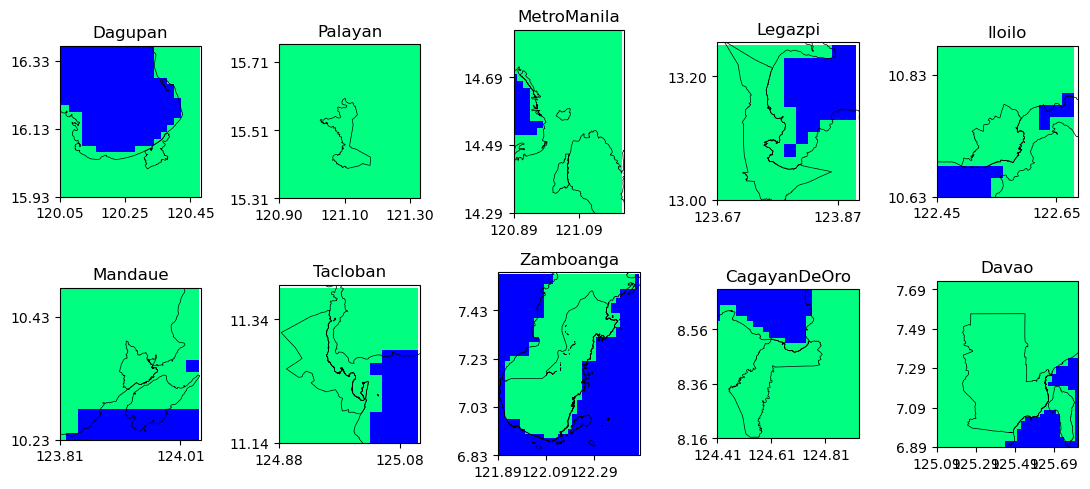

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(11,5),subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
for i,city_name in enumerate(OUTPUT_CITY_NAMES):
    ax=axes[i]
    out_ds = xr.load_dataset(RESULTS_PATH / 'precip' / f"downscaled_precip_{city_name.lower()}_corrected.nc")
    out_ds['elevation_mask'] =  xr.where(~np.isnan(out_ds['precip'].isel(time=0)), 1, 0)
    elev_ds = out_ds[['elevation_mask']]

    elev_ds['elevation_mask'].plot(ax=ax, cmap='winter', add_colorbar=False)
    ph_gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.5)
    city_shp_lookup = city_name_shp_lookup[city_name] if city_name=='MetroManila' else [city_name_shp_lookup[city_name]]
    brgy_gdf[brgy_gdf['ADM3_EN'].isin(city_shp_lookup)].plot(ax=ax, facecolor='none', edgecolor='k', lw=0.5)
    
    lon0, lon1, lat0, lat1 = bounds_df[bounds_df['city']==city_name]['full_bounds'].values[0]
    lon0, lon1, lat0, lat1 = [lon0+0.04, lon1, lat0+0.02, lat1]
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(city_name)
    #ax.coastlines()

    ax.set_xticks(np.arange(lon0, lon1, 10*RESOLUTION), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat0, lat1, 10*RESOLUTION), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.set_xlim([lon0, lon1])
    ax.set_ylim([lat0, lat1])

fig.tight_layout()